In [26]:
%matplotlib notebook

In [109]:
from bluetooth import *
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import datetime

class DataCollector:
    def __init__(self, device_address):
        self.client_socket=BluetoothSocket( RFCOMM )
        self.device_address = device_address
        self.client_socket.connect((device_address,1))
        self.client_socket.send('start')
        self.get_micro_time()

    def listen(self, prefix='', col_count=4):
        """
        Example
        -------
        from btClient import DataCollector
        #data_collector = DataCollector("24:6F:28:B0:2B:1A")#Apr21
        data_collector = DataCollector("24:6F:28:96:A3:B2")#Apr22
        data_collector.listen("./tmp_data.pkl")
        data_collector.client_socket.close()
        """
        if prefix!= '':
            date = datetime.datetime.now()
            filename = "{}_{}_{}_{}.pkl".format(prefix, self.device_address, 
                                                date.strftime("%d-%h-%Y_%H:%M:%S"), self.pc_time)
            f = open(filename,'ab');
        old_data = ''
        while True:
            data = self.client_socket.recv(1024)
            data_str = data.decode()
            data_list = data_str.split("\r\n")
            line_count = len(data_list) - 1
            if line_count==0:
                old_data += data_list[0]
            else:
                line = old_data + data_list[0]
                print(line)
                if 'f' in dir():
                    line_list = line.split("\t")
                    if len(line_list)==col_count:
                        pickle.dump(np.array(line_list, dtype='float'), f)
                old_data = ''
                for counter in range(1,line_count):
                    print(data_list[counter])
                    if 'f' in dir():
                        line_list = data_list[counter].split("\t")
                        if len(line_list)==col_count:
                            pickle.dump(np.array(line_list, dtype='float'), f)

                old_data = data_list[-1]
    
    def plot(self, col_count=4, dim=0):
        """
        Example
        -------
        from btClient import DataCollector
        #data_collector = DataCollector("24:6F:28:B0:2B:1A")#Apr21
        data_collector = DataCollector("24:6F:28:96:A3:B2")#Apr22
        data_collector.listen("./tmp_data.pkl")
        data_collector.client_socket.close()
        """
        line1 = []
        y_vec = np.zeros((300,col_count-1))
        x_vec = np.arange(300)*0.01
        old_data = ''
        while True:
            # Collecting data
            data = self.client_socket.recv(1024)
            data_str = data.decode()
            data_list = data_str.split("\r\n")
            line_count = len(data_list) - 1
            if line_count==0:
                old_data += data_list[0]
            else:
                line = old_data + data_list[0]
                line_list = line.split("\t")
                if len(line_list)==col_count:
                    line_arr = np.array([line_list], dtype='float')
                    y_vec = np.vstack((y_vec[1:],line_arr[:,1:]))
                old_data = ''
                for counter in range(1,line_count):
                    line_list = data_list[counter].split("\t")
                    if len(line_list)==col_count:
                        line_arr = np.array([line_list], dtype='float')
                        y_vec = np.vstack((y_vec[1:],line_arr[:,1:]))
                old_data = data_list[-1]                
                line1 = self.live_plotter(x_vec,y_vec[:,dim],line1)
            
    def live_plotter(self,x_vec,y1_data,line1,identifier='',pause_time=0.01):
        # use ggplot style for more sophisticated visuals
        plt.style.use('ggplot')
        if line1==[]:
            # this is the call to matplotlib that allows dynamic plotting
            plt.ion()
            fig = plt.figure(figsize=(13,6))
            ax = fig.add_subplot(111)
            # create a variable for the line so we can later update it
            line1, = ax.plot(x_vec,y1_data,'-o',alpha=0.8)        
            #update plot label/title
            plt.ylabel('Y Label')
            plt.title('Title: {}'.format(identifier))
            plt.show()
        
        # after the figure, axis, and line are created, we only need to update the y-data
        line1.set_ydata(y1_data)
        # adjust limits if new data goes beyond bounds
        if np.min(y1_data)<=line1.axes.get_ylim()[0] or np.max(y1_data)>=line1.axes.get_ylim()[1]:
            plt.ylim([np.min(y1_data)-np.std(y1_data),np.max(y1_data)+np.std(y1_data)])
        # this pauses the data so the figure/axis can catch up - the amount of pause can be altered above
        plt.pause(pause_time)
        
        # return line so we can update it again in the next iteration
        return line1


    def get_micro_time(self):
        # wait the DMP is ready
        self.client_socket.send("micro time")
        while True:
            msg = self.client_socket.recv(2048)
            #print(msg)
            msg_array = msg.decode().split("\t")
            if msg_array[0]=='micro time:':
                self.micro_time = float(msg_array[-1])/1000
                self.pc_time = time.time()
                break

def read_data(filename):
    objs = []
    with open(filename,'rb') as f:
        while True:
            try:
                objs.append(pickle.load(f))
            except EOFError:
                break
    return objs


In [131]:
#data_collector = DataCollector("24:6F:28:B0:2B:1A")#Apr21
data_collector = DataCollector("24:6F:28:96:A3:B2")#Apr22

In [111]:
#data_collector.listen('hu')

In [112]:
#data_collector = DataCollector("24:6F:28:B0:2B:1A")

In [114]:
import multiprocessing
bt_dict ={"thigh":"24:6F:28:B0:2B:1A","shank":"24:6F:28:96:A3:B2"}
#bt_dict = {"thigh":"24:6F:28:B0:2B:1A"}
#bt_dict = {"shank":"24:6F:28:96:A3:B2"}
data_collectors = {item[0]:DataCollector(item[1]) for item in bt_dict.items()}

In [ ]:
dc = data_collectors['shank']

In [20]:
%matplotlib qt5

In [ ]:
data_collector.plot(dim=2)

In [128]:
process = {item[0]: multiprocessing.Process(target=item[1].listen, args=["walking"]) for item in data_collectors.items()}

In [129]:
for proc in process.values():
    proc.start()

117753	-179.54	179.48	-98.09
117793	-179.54	179.48	-98.08
117773	-179.54	179.48	-98.09
117813	-179.55	179.49	-98.08
117833	-179.55	179.49	-98.08
117853	-179.55	179.49	-98.08
117873	-179.55	179.49	-98.08
117893	-179.55	179.49	-98.08
117913	-179.56	179.50	-98.08
117933	-179.56	179.50	-98.09
117953	-179.56	179.50	-98.09
117973	-179.56	179.50	-98.09
117993	-179.56	179.50	-98.09
118013	-179.56	179.50	-98.09
118033	-179.56	179.50	-98.09
118053	-179.56	179.50	-98.09
118073	-179.56	179.50	-98.09
118093	-179.57	179.51	-98.09
118113	-179.57	179.51	-98.09
118133	-179.57	179.51	-98.09
118153	-179.57	179.51	-98.09
118173	-179.57	179.51	-98.09
118193	-179.57	179.51	-98.09
118213	-179.57	179.51	-98.09
118233	-179.57	179.51	-98.08
118253	-179.57	179.51	-98.08
118273	-179.57	179.51	-98.08
118293	-179.56	179.50	-98.08
118313	-179.55	179.49	-98.08
118333	-179.56	179.50	-98.08
118353	-179.55	179.49	-98.08
118373	-179.55	179.49	-98.09
118393	-179.55	179.49	-98.09
118413	-179.55	179.49	-98.09
118433	-179.54

123408	-179.52	179.45	-98.08
123428	-179.51	179.45	-98.08
123448	-179.52	179.46	-98.08
123468	-179.52	179.46	-98.08
123488	-179.52	179.46	-98.08
123508	-179.52	179.46	-98.09
123528	-179.52	179.45	-98.09
123548	-179.52	179.45	-98.09
123568	-179.51	179.45	-98.08
123588	-179.51	179.45	-98.08
123608	-179.51	179.45	-98.08
123628	-179.51	179.44	-98.07
123648	-179.51	179.44	-98.08
123668	-179.51	179.44	-98.08
123688	-179.51	179.44	-98.08
123708	-179.50	179.44	-98.08
123728	-179.51	179.45	-98.08
123748	-179.51	179.45	-98.08
123768	-179.51	179.45	-98.08
123788	-179.51	179.45	-98.08
123808	-179.51	179.45	-98.08
123828	-179.52	179.45	-98.09
123848	-179.52	179.45	-98.09
123868	-179.52	179.46	-98.08
123888	-179.53	179.47	-98.08
123908	-179.53	179.47	-98.08
123928	-179.53	179.47	-98.07
123948	-179.53	179.47	-98.07
123968	-179.54	179.48	-98.07
123988	-179.54	179.48	-98.08
124008	-179.54	179.48	-98.08
124028	-179.55	179.49	-98.08
124048	-179.56	179.50	-98.08
124068	-179.57	179.51	-98.09
124088	-179.58

129063	-179.53	179.48	-98.05
129083	-179.53	179.48	-98.05
129103	-179.53	179.48	-98.05
129123	-179.54	179.48	-98.05
129144	-179.54	179.49	-98.05
129164	-179.54	179.49	-98.05
129184	-179.54	179.49	-98.05
129204	-179.54	179.49	-98.05
129223	-179.54	179.49	-98.05
129243	-179.54	179.48	-98.05
129263	-179.53	179.48	-98.05
129283	-179.53	179.48	-98.05
129303	-179.54	179.48	-98.06
129323	-179.53	179.47	-98.06
129343	-179.53	179.47	-98.06
129363	-179.53	179.47	-98.06
129383	-179.53	179.47	-98.06
129403	-179.52	179.46	-98.06
129423	-179.52	179.46	-98.05
129443	-179.52	179.46	-98.05
129463	-179.52	179.46	-98.05
129483	-179.52	179.46	-98.05
129503	-179.52	179.46	-98.06
129523	-179.52	179.46	-98.06
129543	-179.51	179.45	-98.07
129563	-179.51	179.45	-98.07
129583	-179.51	179.45	-98.07
129603	-179.52	179.46	-98.07
129623	-179.52	179.46	-98.07
129643	-179.51	179.45	-98.07
129663	-179.51	179.45	-98.06
129683	-179.52	179.46	-98.06
129703	-179.51	179.45	-98.06
129723	-179.52	179.46	-98.06
129743	-179.51

134718	-179.61	179.54	-98.06
134739	-179.60	179.53	-98.06
134759	-179.60	179.53	-98.06
134779	-179.60	179.53	-98.06
134799	-179.60	179.53	-98.06
134818	-179.60	179.54	-98.06
134838	-179.61	179.54	-98.06
134859	-179.61	179.54	-98.05
134879	-179.61	179.55	-98.05
134899	-179.61	179.55	-98.05
134919	-179.61	179.54	-98.05
134938	-179.62	179.55	-98.05
134958	-179.61	179.55	-98.05
134978	-179.61	179.55	-98.05
134998	-179.61	179.54	-98.05
135018	-179.61	179.54	-98.06
135038	-179.61	179.54	-98.06
135058	-179.61	179.54	-98.06
135078	-179.61	179.54	-98.06
135098	-179.60	179.54	-98.06
135118	-179.61	179.54	-98.06
135138	-179.61	179.54	-98.06
135158	-179.61	179.54	-98.06
135178	-179.61	179.54	-98.05
135198	-179.61	179.54	-98.05
135218	-179.61	179.54	-98.06
135238	-179.61	179.54	-98.06
135258	-179.61	179.54	-98.06
135278	-179.61	179.54	-98.06
135298	-179.61	179.54	-98.06
135318	-179.61	179.54	-98.06
135338	-179.61	179.54	-98.06
135358	-179.61	179.55	-98.06
135378	-179.61	179.55	-98.06
135398	-179.62

140374	-179.63	179.55	-98.04
140394	-179.63	179.55	-98.04
140414	-179.63	179.55	-98.04
140434	-179.63	179.55	-98.04
140454	-179.63	179.55	-98.04
140474	-179.63	179.55	-98.04
140494	-179.63	179.54	-98.04
140514	-179.62	179.54	-98.04
140534	-179.62	179.53	-98.03
140554	-179.61	179.53	-98.03
140574	-179.62	179.53	-98.03
140594	-179.62	179.53	-98.03
140614	-179.62	179.53	-98.03
140634	-179.62	179.53	-98.03
140653	-179.62	179.54	-98.03
140674	-179.63	179.54	-98.02
140694	-179.63	179.54	-98.02
140714	-179.63	179.54	-98.02
140733	-179.63	179.54	-98.02
140754	-179.62	179.54	-98.02
140773	-179.62	179.53	-98.03
140793	-179.62	179.53	-98.03
140813	-179.61	179.53	-98.03
140833	-179.62	179.53	-98.03
140853	-179.62	179.53	-98.03
140873	-179.62	179.54	-98.03
140893	-179.63	179.54	-98.03
140913	-179.63	179.55	-98.03
140933	-179.64	179.55	-98.03
140953	-179.64	179.55	-98.03
140973	-179.63	179.55	-98.03
140994	-179.63	179.55	-98.03
141013	-179.63	179.55	-98.03
141034	-179.63	179.54	-98.03
141053	-179.62

146029	-178.70	178.48	-98.04
146049	-178.67	178.45	-98.03
146069	-178.64	178.41	-98.02
146089	-178.62	178.38	-98.02
146109	-178.60	178.37	-98.02
146129	-178.60	178.38	-98.01
146149	-178.61	178.38	-98.01
146169	-178.61	178.39	-98.01
146189	-178.62	178.39	-98.01
146209	-178.62	178.39	-98.01
146229	-178.62	178.40	-98.01
146249	-178.62	178.40	-98.01
146269	-178.63	178.40	-98.02
146289	-178.63	178.40	-98.01
146309	-178.63	178.40	-98.01
146329	-178.63	178.40	-98.02
146349	-178.63	178.40	-98.02
146369	-178.63	178.40	-98.02
146389	-178.64	178.41	-98.02
146408	-178.64	178.42	-98.02
146429	-178.66	178.43	-98.02
146449	-178.66	178.44	-98.02
146469	-178.67	178.45	-98.02
146489	-178.68	178.45	-98.02
146509	-178.68	178.45	-98.02
146528	-178.67	178.45	-98.02
146548	-178.68	178.45	-98.02
146568	-178.68	178.45	-98.02
146588	-178.68	178.46	-98.02
146608	-178.68	178.45	-98.02
146628	-178.68	178.46	-98.02
146648	-178.69	178.46	-98.01
146668	-178.69	178.46	-98.01
146688	-178.70	178.47	-98.01
146708	-178.70

151684	-178.87	178.67	-98.01
151704	-178.87	178.67	-98.01
151724	-178.87	178.67	-98.01
151744	-178.86	178.66	-98.02
151764	-178.86	178.66	-98.01
151784	-178.86	178.66	-98.01
151804	-178.85	178.65	-98.01
151824	-178.86	178.66	-98.01
151844	-178.86	178.65	-98.01
151864	-178.86	178.65	-98.01
151884	-178.86	178.65	-98.01
151904	-178.85	178.65	-98.01
151924	-178.85	178.65	-98.01
151944	-178.86	178.66	-98.01
151964	-178.85	178.65	-98.01
151984	-178.85	178.65	-98.02
152004	-178.85	178.65	-98.02
152024	-178.85	178.65	-98.02
152044	-178.85	178.65	-98.02
152064	-178.86	178.65	-98.02
152084	-178.86	178.66	-98.02
152104	-178.86	178.66	-98.02
152124	-178.86	178.65	-98.02
152144	-178.86	178.65	-98.02
152164	-178.85	178.64	-98.02
152183	-178.84	178.63	-98.02
152203	-178.84	178.63	-98.01
152224	-178.84	178.63	-98.01
152243	-178.84	178.63	-98.01
152264	-178.84	178.64	-98.01
152283	-178.85	178.64	-98.01
152303	-178.85	178.65	-98.01
152324	-178.86	178.65	-98.01
152343	-178.85	178.64	-98.01
152363	-178.85

157339	-178.87	178.66	-97.98
157359	-178.86	178.65	-97.98
157379	-178.86	178.65	-97.98
157399	-178.86	178.65	-97.99
157419	-178.87	178.66	-97.99
157439	-178.87	178.66	-97.99
157459	-178.87	178.66	-97.99
157479	-178.87	178.66	-97.99
157499	-178.87	178.66	-97.99
157519	-178.87	178.66	-98.00
157539	-178.87	178.66	-98.00
157559	-178.87	178.66	-98.00
157579	-178.87	178.66	-97.99
157599	-178.87	178.66	-97.99
157619	-178.88	178.67	-97.99
157639	-178.88	178.67	-97.99
157659	-178.87	178.66	-97.99
157679	-178.87	178.66	-97.99
157699	-178.87	178.66	-97.99
157719	-178.87	178.66	-97.99
157739	-178.87	178.65	-97.99
157759	-178.87	178.65	-98.00
157779	-178.86	178.65	-98.00
157799	-178.87	178.66	-98.00
157819	-178.87	178.66	-98.00
157839	-178.87	178.66	-98.00
157859	-178.87	178.65	-98.00
157879	-178.86	178.65	-98.00
157899	-178.86	178.65	-98.00
157919	-178.86	178.65	-98.00
157939	-178.86	178.65	-98.00
157959	-178.86	178.65	-98.00
157978	-178.86	178.64	-98.00
157999	-178.85	178.64	-98.00
158018	-178.86

In [130]:
for proc in process.values():
    proc.terminate()

In [126]:
multiprocessing.active_children()

[]

### Calibrating YPR

In [36]:
import pandas as pd

In [83]:
#filename = 'walking_24:6F:28:B0:2B:1A_13-May-2020_10:46:56_1589391981.3283944.pkl'
#filename = 'walking_24:6F:28:B0:2B:1A_12-May-2020_21:01:39_1589342449.8474708.pkl'
#filename = 'walking_24:6F:28:B0:2B:1A_13-May-2020_10:59:33_1589392753.5577633.pkl'
#filename = 'walking_24:6F:28:B0:2B:1A_13-May-2020_11:12:47_1589393546.1935096.pkl'
#filename = 'walking_24:6F:28:B0:2B:1A_13-May-2020_11:23:45_1589394205.1475058.pkl'
#filename = 'walking_24:6F:28:96:A3:B2_13-May-2020_11:38:13_1589395052.1726406.pkl'
filename = 'walking_24:6F:28:B0:2B:1A_13-May-2020_19:45:50_1589424322.5427847.pkl'
filename = 'walking_24:6F:28:B0:2B:1A_13-May-2020_19:51:31_1589424671.2255473.pkl'
filename = "walking_24:6F:28:B0:2B:1A_13-May-2020_20:17:37_1589426231.2571287.pkl"
filename = 'walking_24:6F:28:96:A3:B2_14-May-2020_00:19:57_1589440735.2947056.pkl'
filename = 'walking_24:6F:28:96:A3:B2_14-May-2020_00:25:34_1589441103.801488.pkl'


In [84]:
df1 = pd.DataFrame(read_data(filename), columns=['micro_time','yaw', 'pitch', 'roll'])

In [85]:
df1.set_index('micro_time',inplace=True)

In [86]:
#plt.figure()
#plt.plot(np.diff(df1.index.values),'.-')

In [87]:
plt.figure()
#plt.plot(df1[['pitch']].apply(np.unwrap,discont=15),'.-')
#plt.plot(df1[['pitch']],'.-')
plt.plot(df1[['roll']],'r.-')

In [409]:
a = df1[['pitch']].values

In [424]:
a_mask_n90 = (a > -90)
a_mask_p90 = (a > 90)

In [497]:
def correct(x):
    if x > 90:
        return -(x-180)
    elif (x > -90) & (x<0):
        return -(x+180)
    return x

<IPython.core.display.Javascript object>


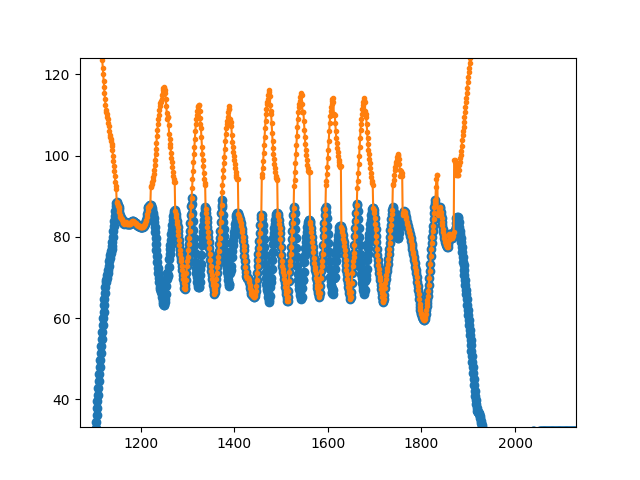

In [498]:
plt.figure()
plt.plot(np.apply_along_axis(correct,1,df1[['yaw']].values),'o-')
plt.plot(df1[['yaw']].values,'.-')

In [477]:
np.apply_along_axis?

In [435]:
a1 = a*(~a_mask_n90)
a2 = a*(~a_mask_p90)
#a_p90 = -(a-180)*(a_mask_p90)
#a_n90 = -(a+180)*(a_mask_n90)
a

<IPython.core.display.Javascript object>


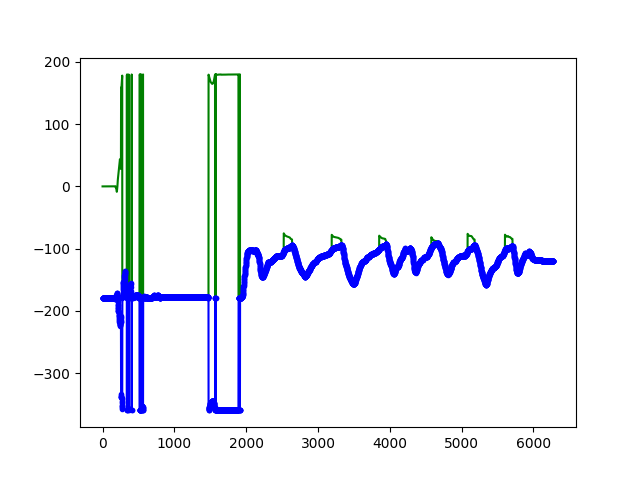

In [437]:
plt.figure()
#plt.plot(a,'g')
#plt.plot(a_p90+a2,'.-r')
plt.plot(a,'g')
plt.plot(a_n90+a1,'.-b')
#plt.plot(a1+a_n90,'green')
#plt.plot(a2+a_p90,'blue')
#plt.plot(a_p90,'black')
#plt.plot(a_n90,'red')
#plt.plot()

In [286]:
a11 = -a1-180*a_mask

<IPython.core.display.Javascript object>


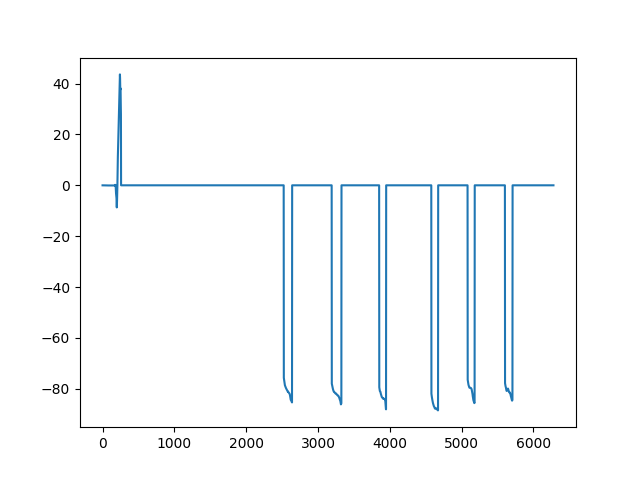

In [319]:
plt.figure()
plt.plot(a1)
#plt.plot(a1,'r');
#plt.plot(a2+a11,'.-b');
#plt.plot(a11,'g');

In [161]:
df1[['pitch']].plot()

In [162]:
df1[['pitch']].apply(np.unwrap,discont=180).plot()

## Analyzing Data

In [31]:
import pandas as pd

In [65]:
bt_dict = {"thigh":"walking_24:6F:28:B0:2B:1A_12-May-2020_20:26:06_1589340326.9077148.pkl",
           "shank":"walking_24:6F:28:B0:2B:1A_14-May-2020_00:50:41_1589442553.183885.pkl"}

In [66]:
df1 = pd.DataFrame(read_data(bt_dict["thigh"]), columns=['micro_time','yaw', 'pitch', 'roll'])
df2 = pd.DataFrame(read_data(bt_dict["shank"]), columns=['micro_time','yaw', 'pitch', 'roll'])

In [67]:
df1_pc_time = float(bt_dict["thigh"].split('_')[-1].split('.pkl')[0])
df2_pc_time = float(bt_dict["shank"].split('_')[-1].split('.pkl')[0])

In [68]:
df1['micro_time'] = df1['micro_time']/1000+df1_pc_time
df2['micro_time'] = df2['micro_time']/1000+df2_pc_time

In [69]:
df1.set_index('micro_time',inplace=True)
df2.set_index('micro_time',inplace=True)

In [70]:
df1 = df1.apply(lambda x: np.unwrap(x, discont=180))
df2 = df2.apply(lambda x: np.unwrap(x, discont=180))

### Normalizing time

In [71]:
i = np.sort(np.hstack([df1.index.values,df2.index.values]))

In [72]:
dF1=pd.DataFrame({},index=i)
dF2=pd.DataFrame({},index=i)

In [73]:
col_names = ['yaw','pitch','roll']

In [74]:
dF1[col_names]=df1[col_names]
dF2[col_names]=df2[col_names]

In [75]:
dF1.interpolate(inplace=True)
dF2.interpolate(inplace=True)

In [76]:
%matplotlib notebook

<IPython.core.display.Javascript object>


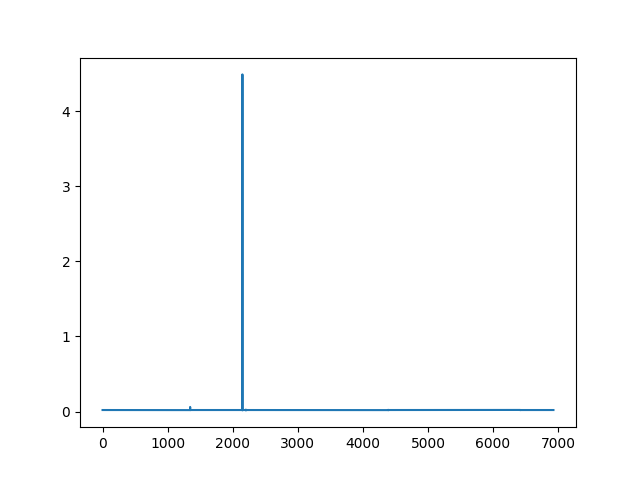

In [78]:
plt.figure()
plt.plot(np.diff(df1.index.values))

<IPython.core.display.Javascript object>


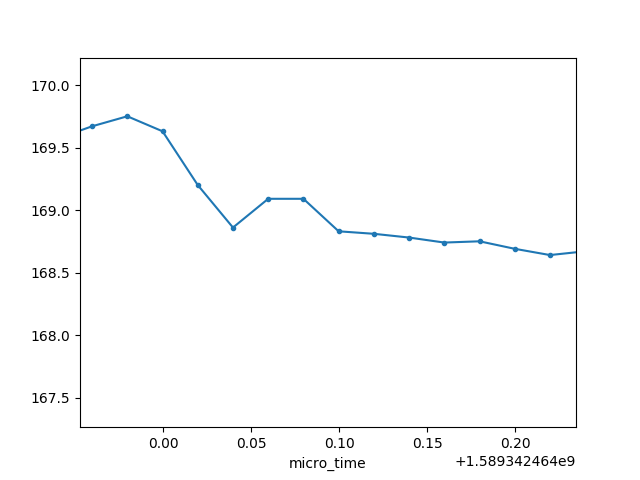

In [102]:
plt.figure()
#plt.plot(dF1['pitch'],'*-')
plt.plot(df1['pitch'],'.-')

In [86]:
len(dF1['pitch'])

13986

<IPython.core.display.Javascript object>


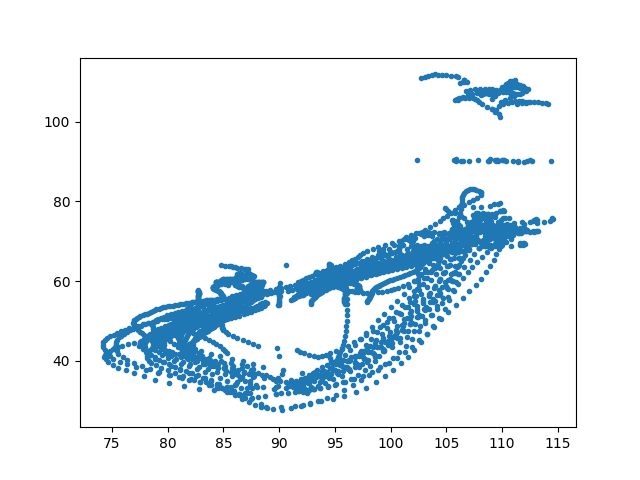

In [99]:
plt.figure()
start = 8000
end = 11000
plt.plot(dF1['pitch'].values[start:end],dF2['pitch'].values[start:end],'.')
#dF1['pitch'].plot()
#dF2['pitch'].plot()

In [189]:
dF2.plot()

In [185]:
plt.figure()
theta = 80
plt.plot([0,np.cos(np.pi*theta/180)],[0,np.sin(np.pi*theta/180)],'*-')
plt.axis('equal')

(-0.008682408883346522,
 0.18233058655027692,
 -0.0492403876506104,
 1.0340481406628184)